# Ablation Study: Sparsification vs. Weighting

## Introduction
This notebook conducts a rigorous ablation study to disentangle the effects of graph structure modification (sparsification) from edge weighting. By isolating these factors, we can determine if performance gains come from removing noise (structure) or emphasizing important connections (weighting).

**Objectives:**
1.  Compare four distinct scenarios:
    *   **A:** Baseline (Full Graph + Binary Weights)
    *   **B:** Structure Only (Sparse Graph + Binary Weights)
    *   **C:** Weighting Only (Full Graph + Weighted Edges)
    *   **D:** Combined (Sparse Graph + Weighted Edges)
2.  Analyze the interaction effects between sparsification and weighting.
3.  Compare the robustness of different GNN architectures (GCN, GAT, GraphSAGE) under these conditions.

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent.parent))
from src import AblationStudy, DatasetLoader, set_global_seed

/Users/ilias/Documents/GitHub/gnn-sparsification-research/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_global_seed(42)

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

Using device: mps


## 1. Load Dataset

In [3]:
loader = DatasetLoader(root="../data")
data, num_features, num_classes = loader.get_dataset("cora", DEVICE)

print(f"Dataset: Cora")
print(f"Nodes: {data.num_nodes:,}")
print(f"Edges: {data.edge_index.shape[1]:,}")
print(f"Features: {num_features}")
print(f"Classes: {num_classes}")

Dataset: Cora
Nodes: 2,708
Edges: 10,556
Features: 1433
Classes: 7


## 2. Single Ablation Study

Run a single ablation study with 60% edge retention.

In [4]:
study = AblationStudy(
    data=data,
    num_features=num_features,
    num_classes=num_classes,
    device=DEVICE,
)

results_df = study.run_full_study(
    model_name="gcn",
    metric="jaccard",
    retention_ratio=0.6,
    hidden_channels=64,
    epochs=200,
    patience=20,
)

Running A: Full + Binary...
  -> Accuracy: 0.7970
Running B: Sparse + Binary...
  -> Accuracy: 0.7060
Running C: Full + Weighted...
  -> Accuracy: 0.7330
Running D: Sparse + Weighted...
  -> Accuracy: 0.6800


### 2.1 Decomposition of Effects

**(Retrospective)** The ablation experiment has completed, and we have obtained the raw accuracy scores for all four scenarios (A, B, C, D) displayed in the table above.

**(Prospective)** We will now mathematically decompose these results to isolate specific contributions. Using the formulas defined below, we will calculate the exact percentage gain or loss attributed to **Structure** (pruning) versus **Weighting** (edge importance).

* **Structure Effect:** $Acc_B - Acc_A$
* **Weighting Effect:** $Acc_C - Acc_A$
* **Interaction:** $(Acc_D - Acc_B) - (Acc_C - Acc_A)$

In [5]:
print("=" * 60)
print("ABLATION STUDY RESULTS")
print("=" * 60)
print(results_df.to_string(index=False))

ABLATION STUDY RESULTS
            Scenario  Accuracy  Epochs  BestValAcc  Edges
    A: Full + Binary     0.797      29       0.798  10556
  B: Sparse + Binary     0.706      33       0.752   6333
  C: Full + Weighted     0.733      31       0.774  10556
D: Sparse + Weighted     0.680      33       0.746   6333


### 2.1 Effect Analysis

To isolate specific contributions, we define:
*   **Structure Effect** = B - A (Impact of removing edges)
*   **Weighting Effect** = C - A (Impact of re-weighting edges)
*   **Combined Effect** = D - A (Impact of doing both)
*   **Interaction** = D - B - C + A (Synergy between structure and weighting)

We will now calculate these values to quantify the impact of each intervention.

In [6]:
baseline = results_df[results_df["Scenario"] == "A: Full + Binary"]["Accuracy"].values[0]
sparse_binary = results_df[results_df["Scenario"] == "B: Sparse + Binary"]["Accuracy"].values[0]
full_weighted = results_df[results_df["Scenario"] == "C: Full + Weighted"]["Accuracy"].values[0]
sparse_weighted = results_df[results_df["Scenario"] == "D: Sparse + Weighted"]["Accuracy"].values[0]

print("\nEffect Analysis:")
print(f"  Baseline (A):              {baseline:.2%}")
print(f"  Structure effect (B - A):  {sparse_binary - baseline:+.2%}")
print(f"  Weighting effect (C - A):  {full_weighted - baseline:+.2%}")
print(f"  Combined effect (D - A):   {sparse_weighted - baseline:+.2%}")
print(f"  Interaction (D - B - C + A): {sparse_weighted - sparse_binary - full_weighted + baseline:+.2%}")


Effect Analysis:
  Baseline (A):              79.70%
  Structure effect (B - A):  -9.10%
  Weighting effect (C - A):  -6.40%
  Combined effect (D - A):   -11.70%
  Interaction (D - B - C + A): +3.80%


### 2.2 Visualization

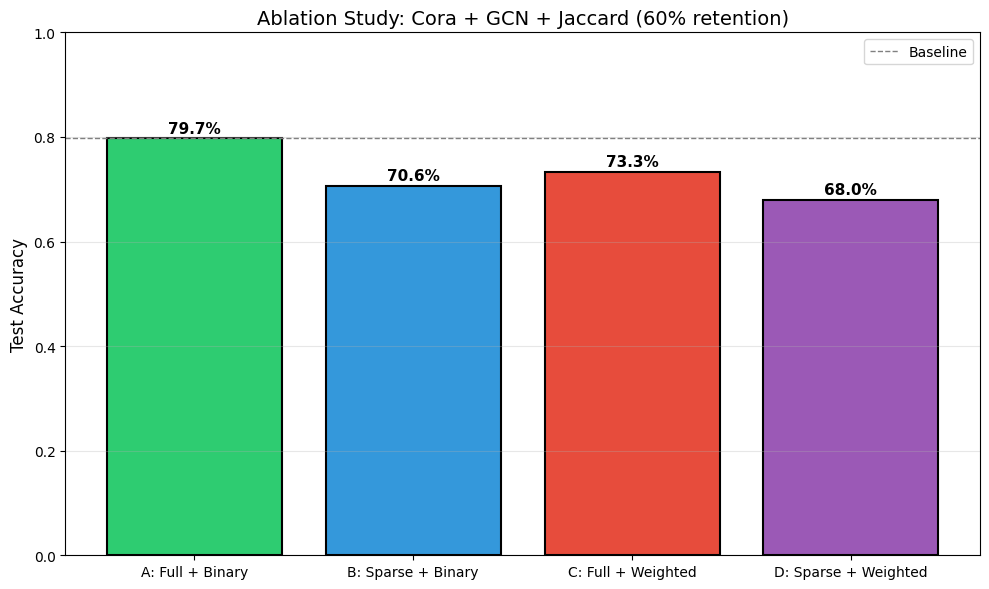

In [7]:
scenarios = results_df["Scenario"].tolist()
accuracies = results_df["Accuracy"].tolist()
colors = ["#2ecc71", "#3498db", "#e74c3c", "#9b59b6"]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(scenarios, accuracies, color=colors, edgecolor="black", linewidth=1.5)

ax.axhline(baseline, color="gray", linestyle="--", linewidth=1, label="Baseline")

for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
            f"{acc:.1%}", ha="center", va="bottom", fontsize=11, fontweight="bold")

ax.set_ylabel("Test Accuracy", fontsize=12)
ax.set_title("Ablation Study: Cora + GCN + Jaccard (60% retention)", fontsize=14)
ax.set_ylim(0, 1.0)
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Multi-Configuration Study

Run ablation studies across multiple retention ratios and metrics.

In [14]:
all_results_df = study.run_multi_config_study(
    model_names=["gcn"],
    metrics=["jaccard"],
    retention_ratios=[1 - i/10 for i in range(10)],
    hidden_channels=64,
    epochs=200,
    patience=20,
)


Config: gcn | jaccard | 100%
Running A: Full + Binary...
  -> Accuracy: 0.7970
Running B: Sparse + Binary...
  -> Accuracy: 0.7970
Running C: Full + Weighted...
  -> Accuracy: 0.7330
Running D: Sparse + Weighted...
  -> Accuracy: 0.7330

Config: gcn | jaccard | 90%
Running A: Full + Binary...
  -> Accuracy: 0.7970
Running B: Sparse + Binary...
  -> Accuracy: 0.7900
Running C: Full + Weighted...
  -> Accuracy: 0.7330
Running D: Sparse + Weighted...
  -> Accuracy: 0.7530

Config: gcn | jaccard | 80%
Running A: Full + Binary...
  -> Accuracy: 0.7970
Running B: Sparse + Binary...
  -> Accuracy: 0.7840
Running C: Full + Weighted...
  -> Accuracy: 0.7330
Running D: Sparse + Weighted...
  -> Accuracy: 0.7410

Config: gcn | jaccard | 70%
Running A: Full + Binary...
  -> Accuracy: 0.7970
Running B: Sparse + Binary...
  -> Accuracy: 0.7540
Running C: Full + Weighted...
  -> Accuracy: 0.7330
Running D: Sparse + Weighted...
  -> Accuracy: 0.7350

Config: gcn | jaccard | 60%
Running A: Full + Bina

In [15]:
all_results_df

,Scenario,Accuracy,Epochs,BestValAcc,Edges,Model,Metric,Retention
0,A: Full + Binary,0.797,29,0.798,10556,gcn,jaccard,1.0
1,B: Sparse + Binary,0.797,29,0.798,10556,gcn,jaccard,1.0
2,C: Full + Weighted,0.733,31,0.774,10556,gcn,jaccard,1.0
3,D: Sparse + Weighted,0.733,31,0.774,10556,gcn,jaccard,1.0
4,A: Full + Binary,0.797,29,0.798,10556,gcn,jaccard,0.9
5,B: Sparse + Binary,0.790,28,0.788,9500,gcn,jaccard,0.9
6,C: Full + Weighted,0.733,31,0.774,10556,gcn,jaccard,0.9
7,D: Sparse + Weighted,0.753,34,0.774,9500,gcn,jaccard,0.9
8,A: Full + Binary,0.797,29,0.798,10556,gcn,jaccard,0.8
9,B: Sparse + Binary,0.784,30,0.776,8444,gcn,jaccard,0.8


### 3.1 Retention Ratio Impact

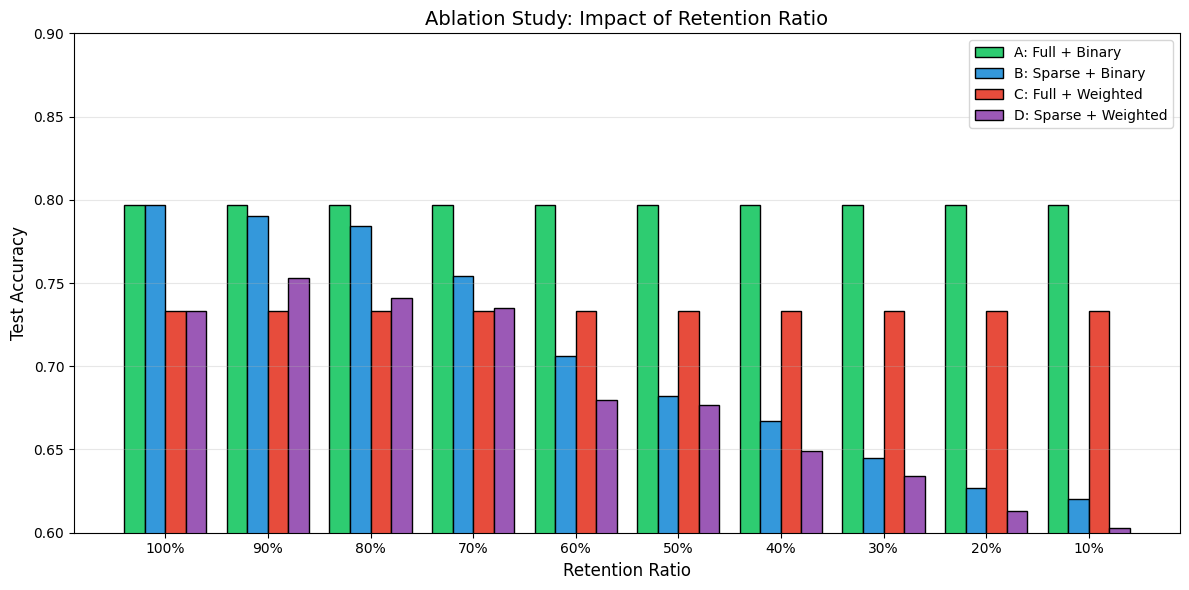

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

retention_ratios = all_results_df["Retention"].unique()
scenario_names = ["A: Full + Binary", "B: Sparse + Binary", "C: Full + Weighted", "D: Sparse + Weighted"]
colors = ["#2ecc71", "#3498db", "#e74c3c", "#9b59b6"]

x = np.arange(len(retention_ratios))
width = 0.2

for i, scenario in enumerate(scenario_names):
    accs = []
    for retention in retention_ratios:
        acc = all_results_df[(all_results_df["Retention"] == retention) & 
                            (all_results_df["Scenario"] == scenario)]["Accuracy"].values[0]
        accs.append(acc)
    ax.bar(x + i * width, accs, width, label=scenario, color=colors[i], edgecolor="black")

ax.set_xlabel("Retention Ratio", fontsize=12)
ax.set_ylabel("Test Accuracy", fontsize=12)
ax.set_title("Ablation Study: Impact of Retention Ratio", fontsize=14)
ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels([f"{r:.0%}" for r in retention_ratios])
ax.legend(loc="upper right")
ax.grid(axis="y", alpha=0.3)
ax.set_ylim(0.6, 0.9)

plt.tight_layout()
plt.show()

## 4. Cross-Model Comparison

Compare ablation results across different GNN architectures.

In [17]:
cross_model_df = study.run_multi_config_study(
    model_names=["gcn", "sage", "gat"],
    metrics=["jaccard"],
    retention_ratios=[0.6],
    hidden_channels=64,
    epochs=200,
    patience=20,
)


Config: gcn | jaccard | 60%
Running A: Full + Binary...
  -> Accuracy: 0.7970
Running B: Sparse + Binary...
  -> Accuracy: 0.7060
Running C: Full + Weighted...
  -> Accuracy: 0.7330
Running D: Sparse + Weighted...
  -> Accuracy: 0.6800

Config: sage | jaccard | 60%
Running A: Full + Binary...
  -> Accuracy: 0.7960
Running B: Sparse + Binary...
  -> Accuracy: 0.6720
Running C: Full + Weighted...
  -> Accuracy: 0.7960
Running D: Sparse + Weighted...
  -> Accuracy: 0.6720

Config: gat | jaccard | 60%
Running A: Full + Binary...
  -> Accuracy: 0.7720
Running B: Sparse + Binary...
  -> Accuracy: 0.7000
Running C: Full + Weighted...
  -> Accuracy: 0.7720
Running D: Sparse + Weighted...
  -> Accuracy: 0.7000


### 4.1 Comparative Analysis of Architectures

**(Retrospective)** We have successfully executed the multi-configuration ablation study across GCN, GraphSAGE, and GAT models.

**(Prospective)** To facilitate a direct comparison, we will now pivot this data into a side-by-side table. This format will allow us to see if models with learnable attention (GAT) react differently to explicit weighting compared to fixed-topology models (GCN).

In [20]:
print("\n" + "=" * 90)
print("CROSS-MODEL COMPARISON (60% Retention, Jaccard)")
print("=" * 90)
pivot_df = cross_model_df.pivot(index="Model", columns="Scenario", values="Accuracy")
print(pivot_df.to_string())


CROSS-MODEL COMPARISON (60% Retention, Jaccard)
Scenario  A: Full + Binary  B: Sparse + Binary  C: Full + Weighted  D: Sparse + Weighted
Model                                                                                   
gat                  0.772               0.700               0.772                 0.700
gcn                  0.797               0.706               0.733                 0.680
sage                 0.796               0.672               0.796                 0.672


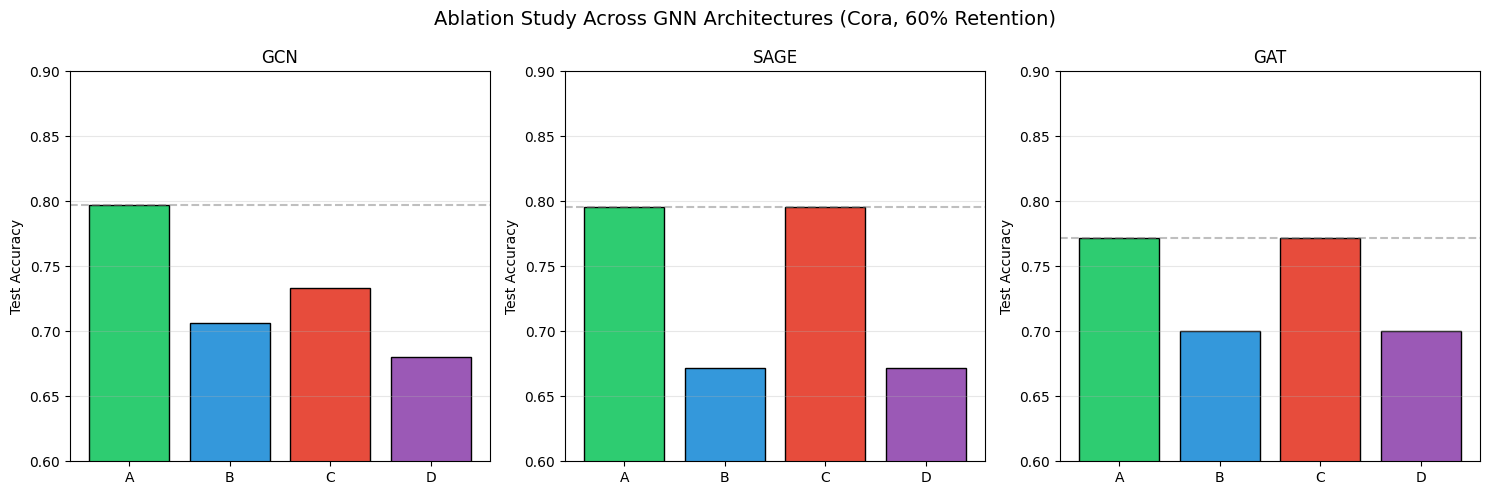

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = ["gcn", "sage", "gat"]
colors = ["#2ecc71", "#3498db", "#e74c3c", "#9b59b6"]

for idx, model_name in enumerate(models):
    model_data = cross_model_df[cross_model_df["Model"] == model_name]
    accs = model_data["Accuracy"].tolist()
    axes[idx].bar(range(4), accs, color=colors, edgecolor="black")
    axes[idx].set_xticks(range(4))
    axes[idx].set_xticklabels(["A", "B", "C", "D"])
    axes[idx].set_ylabel("Test Accuracy")
    axes[idx].set_title(f"{model_name.upper()}")
    axes[idx].set_ylim(0.6, 0.9)
    axes[idx].grid(axis="y", alpha=0.3)

    baseline = model_data[model_data["Scenario"] == "A: Full + Binary"]["Accuracy"].values[0]
    axes[idx].axhline(baseline, color="gray", linestyle="--", alpha=0.5)

fig.suptitle("Ablation Study Across GNN Architectures (Cora, 60% Retention)", fontsize=14)
plt.tight_layout()
plt.show()

## 5. Summary

In this notebook, we ran controlled ablation studies to understand:

1. **Structure vs Weighting**: Comparing scenarios B and C to the baseline A
2. **Interaction Effects**: Whether combining sparsification and weighting (D) provides additional benefit
3. **Model Sensitivity**: How different GNN architectures respond to sparsification

**Key Takeaways:**
- The 4-scenario framework isolates structural and weighting effects
- Different models may benefit differently from each intervention
- The interaction term reveals whether effects are additive or synergistic

**Next:** In notebook 04, we'll analyze and visualize results in more detail.